In [238]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [239]:
def dilation(img, kernel=np.ones((3, 3), np.uint8)):
    """
    param img: input image
    param kernel: kernel
    return: dilation image
    """
    # Create an empty output image
    output = np.zeros_like(img)

    # Pad the input image with zeros
    img_padded = np.pad(img, ((1, 1), (1, 1)), mode="constant", constant_values=0)

    # Loop over the pixels of the input image
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Compute the maximum pixel value under the kernel
            values = img_padded[i : i + kernel.shape[0], j : j + kernel.shape[1]]
            output[i, j] = np.max(values)
    return output


def erosion(img, kernel=np.ones((3, 3), np.uint8)):
    """
    param img: input imageD
    param kernel: kernel
    return: erosion image
    """
    # Create an empty output image
    output = np.zeros_like(img)

    # Pad the input image with zeros
    img_padded = np.pad(img, ((1, 1), (1, 1)), mode="constant", constant_values=0)

    # Loop over the pixels of the input image
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Compute the minimum pixel value under the kernel
            values = img_padded[i : i + kernel.shape[0], j : j + kernel.shape[1]]
            output[i, j] = np.min(values)
    return output


def opening(img, kernel):
    """
    param img: input image
    """
    # first erosion, then dilation
    img_opening = erosion(img, kernel)
    img_opening = dilation(img_opening, kernel)
    return img_opening


def closing(img, kernel):
    """ """
    # first dilation, then erosion
    img_closing = dilation(img, kernel)
    img_closing = erosion(img_closing, kernel)
    return img_closing



def img_to_gray(img):
    """
    param img: input image
    return: gray image
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def top_hat(img, kernel, iter):
    """
    param img: input image
    """  
    return cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel, iterations=iter)


def image_color_segmentation(img, threshold):
    """
    param img: input image

    """
    # extract the color channels
    img = img.astype(np.uint8)
    background = img

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if background[i, j] >= threshold:
                img[i, j] = 255
            else:
                img[i, j] = 0

    return img


class ColorSpace:
    def __init__(self):
        self.pixel_value = 0
        self.color_value = 0


def region_coloring(img):
    """
    region identification and coloring

    """
    # tmp_img = np.zeros_like(gray_img, dtype=ColorSpace)
    tmp_img = [[ColorSpace() for i in range(img.shape[1])] for j in range(img.shape[0])]
    tmp_img = np.array(tmp_img)

    for i in range(tmp_img.shape[0]):
        for j in range(tmp_img.shape[1]):
            if img[i, j] != 0:
                tmp_img[i, j].pixel_value = 1
                tmp_img[i, j].color_value = 0

    uniqe_color_iterator = 1
    iter = 0

    while True:
        flag_changed_color = False
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if i > 0 and j > 0 and i < img.shape[0] - 1 and j < img.shape[1] - 1:
                    if tmp_img[i, j].pixel_value == 1:
                        mask = np.array(
                            [
                                tmp_img[i - 1, j - 1],
                                tmp_img[i - 1, j],
                                tmp_img[i - 1, j + 1],
                                tmp_img[i, j - 1],
                                tmp_img[i, j + 1],
                                tmp_img[i + 1, j - 1],
                                tmp_img[i + 1, j],
                                tmp_img[i + 1, j + 1],
                            ],
                        )

                        # get non black pixels from mask
                        color = [
                            x.color_value
                            for x in mask
                            if x.pixel_value == 1 and x.color_value != 0
                        ]

                        # if there is no non black pixel in mask
                        if len(color) == 0 and tmp_img[i, j].pixel_value == 1:
                            tmp_img[i, j].color_value = uniqe_color_iterator
                            uniqe_color_iterator += 1
                            flag_changed_color = True
                        elif (
                            tmp_img[i, j].pixel_value == 1
                            and min(color) != tmp_img[i, j].color_value
                        ):
                            tmp_img[i, j].color_value = min(color)
                            flag_changed_color = True
        iter += 1
        if flag_changed_color == False or iter > 20:
            break

    final_img = np.zeros_like(img, dtype=np.float32)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if tmp_img[i, j].pixel_value == 1:
                color = tmp_img[i, j].color_value
                final_img[i, j] = color
    return final_img


def center_of_mass(img):
    centers = []
    for i in np.unique(img):
        mask = img == i
        y, x = np.where(mask)
        if i != 0:
            centers.append((np.mean(x), np.mean(y)))
    return centers

Proveďte  segmentaci obrázku  cv10_mince.bmp,  výsledný  segmentovaný obraz upravte vhodnou morfologickou operací.

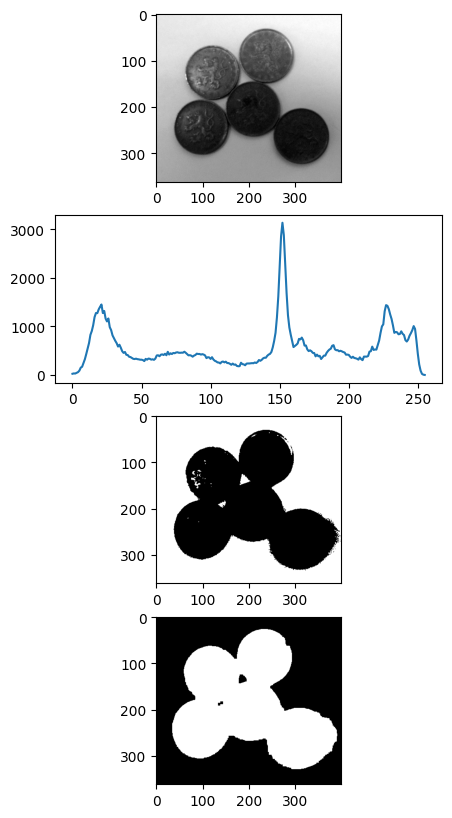

In [240]:
img_mince = cv2.imread("cv10_mince.jpg", cv2.IMREAD_GRAYSCALE)
img_mince_color = cv2.imread("cv10_mince.jpg", cv2.IMREAD_COLOR)


sub_size = 4
plt.figure(figsize=(5, 10))
plt.subplot(sub_size,1,1)
plt.imshow(img_mince, cmap="gray")

# histogram plot
plt.subplot(sub_size,1,2)
hist = cv2.calcHist([img_mince], [0], None, [256], [0, 256])
plt.plot(hist)


# segmentation of the image
image_color_segmentation = image_color_segmentation(img_mince, 140)

# plot the segmented image
plt.subplot(sub_size,1,3)
plt.imshow(image_color_segmentation, cmap="gray")

# invert the image
image_color_segmentation = cv2.bitwise_not(image_color_segmentation)

kernel = np.ones((5,5),np.uint8)

# use the opening operation to remove the noise
closing_img = closing(image_color_segmentation, kernel)
opening_img = opening(closing_img, kernel)

# sure background area - use dilation
#morphed_img = dilation(opening_img, kernel)
morphed_img = opening_img

# plot the segmented image
plt.subplot(sub_size,1,4)
plt.imshow(morphed_img, cmap="gray")





Ve  výsledném  objektu  oddělte  jednotlivé  objekty  mincí  s využitím  funkce pro rozvodí (watershed).

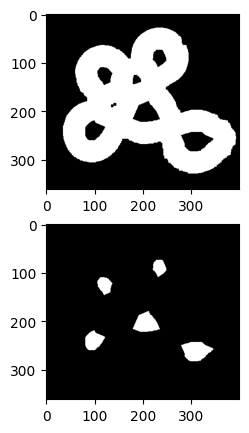

In [241]:
# watershed segmentation
distace = cv2.distanceTransform(morphed_img, cv2.DIST_L2, 3)
ret , sure_fg = cv2.threshold(distace, 0.7*distace.max(), 255, 0)

# find unknown region
sure_fg = np.uint8(sure_fg)
morphed_img = np.uint8(morphed_img)
unknown = cv2.subtract(morphed_img, sure_fg)

# plot unknown region
sub_size = 2
plt.figure(figsize=(5, 5))
plt.subplot(sub_size,1,1)
plt.imshow(unknown, cmap="gray")

# plot sure foreground
plt.subplot(sub_size,1,2)
plt.imshow(sure_fg, cmap="gray")





Identifikujte objekty mincí  pomocí funkce  barvení  oblastí  a spočítejte  jejich  těžiště.  Objekty,  které  byly  odděleny  transformací  rozvodí,  a  které  nejsou  mincemi  neidentifikujte  (například  na  základě  velikosti  objektů).

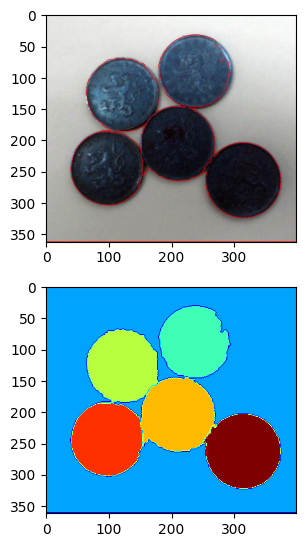

In [244]:
# region_coloring_img = region_coloring(sure_fg)
# plt.figure(figsize=(5, 5))
# plt.imshow(region_coloring_img, cmap="jet")


#  For this we use cv2.connectedComponents(). It labels background of the image with 0, then other objects are labelled with integers starting from 1.
markers = cv2.connectedComponents(sure_fg)[1]
markers = markers + 1
markers[unknown == 255] = 0

# morphed_img to RGB


# apply watershed
markers_water = cv2.watershed(img_mince_color, markers)
img_mince_color[markers_water == -1] = [255, 0, 0]

sub_size = 3
plt.figure(figsize=(5, 10))
plt.subplot(sub_size,1,1)
plt.imshow(img_mince_color, cmap="jet")
plt.subplot(sub_size,1,2)
plt.imshow(markers_water, cmap="jet")

coin is:  2  with pixels:  9900
coin is:  3  with pixels:  10383
coin is:  4  with pixels:  11088
coin is:  5  with pixels:  10582
coin is:  6  with pixels:  11236


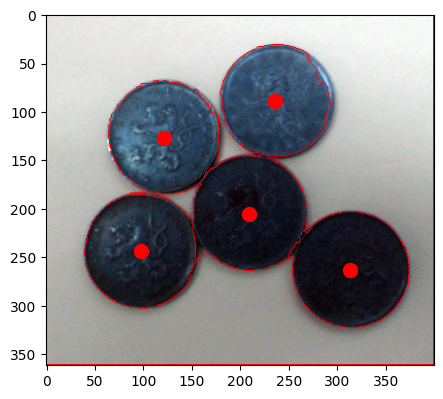

In [253]:
coins = []
for region in np.unique(markers_water):
    pixels = np.sum(markers_water == region)
    if region != 1 and region != -1 and pixels > 9000 and pixels < 12000:
        mask = markers_water == region
        y, x = np.where(mask)
        coins.append((np.mean(x), np.mean(y)))
        print("coin is: ", region, " with pixels: ", pixels)
plt.figure(figsize=(5, 5))
plt.imshow(img_mince_color, cmap="jet")
plt.scatter([x[0] for x in coins], [x[1] for x in coins], c="r", s=100)